In [1]:
# import relevant libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
from sklearn.cluster import KMeans
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')
import pickle

In [2]:
# create list of all stations
with open("stations.txt","r") as stations_file:
    stations = [station.strip() for station in stations_file.readlines()]

In [3]:
# set appropriate widths to read fixed width file into pandas dataframe
widths = [9, 4, 8, 9, 7, 8, 8, 11]

# create dictionary to store dataframes of all stations
stations_dict = {}
for station in stations:
    stations_dict[station] = pd.read_fwf("./weather_data/" + station + ".txt", widths=widths, header=None)

# view raw datasets of all stations
stations_dict

{'aberporth':         0   1     2    3    4      5      6            7
 0    1941   1   ---  ---  ---   74.7    ---          NaN
 1    1941   2   ---  ---  ---   69.1    ---          NaN
 2    1941   3   ---  ---  ---   76.2    ---          NaN
 3    1941   4   ---  ---  ---   33.7    ---          NaN
 4    1941   5   ---  ---  ---   51.3    ---          NaN
 ..    ...  ..   ...  ...  ...    ...    ...          ...
 958  2020  11  11.7  6.8    0   70.8  55.6#  Provisional
 959  2020  12   8.6  4.6    0  190.4  25.3#  Provisional
 960  2021   1   6.9  2.8    7  138.0  38.0#  Provisional
 961  2021   2   7.9  2.9    6  119.4  60.6#  Provisional
 962  2021   3   9.8  4.6    3   38.8  94.7#  Provisional
 
 [963 rows x 8 columns],
 'armagh':          0   1     2    3    4      5      6            7
 0     1853   1   ---  ---  ---   57.3    ---          NaN
 1     1853   2   ---  ---  ---   32.3    ---          NaN
 2     1853   3   ---  ---  ---   65.5    ---          NaN
 3     1853   4   

In [4]:
# clean data for all stations
for station in stations_dict:
    
    # cleaning only numeric columns 2-6
    for column in range(2,7):
        
        # convert column values to string for data manipulation
        stations_dict[station].iloc[:,column] = np.array(stations_dict[station].iloc[:,column]).astype(str)
        
        # check each value in column for irregularities and correct them
        for i in range(len(stations_dict[station].iloc[:,column])):
            
            # change variants of '---' into 'nan' if it exists
            if '---' in stations_dict[station].iloc[:,column][i]:
                stations_dict[station].iloc[:,column][i] = 'nan'
            
            # check for *, #, or $ in the last character and remove if found
            if stations_dict[station].iloc[:,column][i][-1] == '*' or stations_dict[station].iloc[:,column][i][-1] == '#' or stations_dict[station].iloc[:,column][i][-1] == '$':
                stations_dict[station].iloc[:,column][i] = stations_dict[station].iloc[:,column][i][:-1]
            
            # check for alphabetic characters in the last three characters of value and remove them if found
            if re.findall("[a-zA-Z]", stations_dict[station].iloc[:,column][i][-3:]):
                stations_dict[station].iloc[:,column][i] = stations_dict[station].iloc[:,column][i][:-3]
            # correct empty strings created for 'nan' resulting from re.findall() logic above
            if stations_dict[station].iloc[:,column][i] == '':
                stations_dict[station].iloc[:,column][i] = 'nan' 
        
        # convert column values into floats after cleaning strings
        stations_dict[station].iloc[:,column] = stations_dict[station].iloc[:,column].astype(np.float)

In [5]:
# view cleaned datasets for all stations
stations_dict

{'aberporth':         0   1     2    3    4      5     6            7
 0    1941   1   NaN  NaN  NaN   74.7   NaN          NaN
 1    1941   2   NaN  NaN  NaN   69.1   NaN          NaN
 2    1941   3   NaN  NaN  NaN   76.2   NaN          NaN
 3    1941   4   NaN  NaN  NaN   33.7   NaN          NaN
 4    1941   5   NaN  NaN  NaN   51.3   NaN          NaN
 ..    ...  ..   ...  ...  ...    ...   ...          ...
 958  2020  11  11.7  6.8  0.0   70.8  55.6  Provisional
 959  2020  12   8.6  4.6  0.0  190.4  25.3  Provisional
 960  2021   1   6.9  2.8  7.0  138.0  38.0  Provisional
 961  2021   2   7.9  2.9  6.0  119.4  60.6  Provisional
 962  2021   3   9.8  4.6  3.0   38.8  94.7  Provisional
 
 [963 rows x 8 columns],
 'armagh':          0   1     2    3     4      5     6            7
 0     1853   1   NaN  NaN   NaN   57.3   NaN          NaN
 1     1853   2   NaN  NaN   NaN   32.3   NaN          NaN
 2     1853   3   NaN  NaN   NaN   65.5   NaN          NaN
 3     1853   4   NaN  NaN   N

In [6]:
# save cleaned stations_dict data into a file for later reuse
with open("./weather_data/stations_dict.pkl", "wb") as f:
    pickle.dump(stations_dict, f)

In [7]:
# create new dataframe with rows for all stations and fill with average numeric values
stations_averages = pd.DataFrame(index=stations, 
                  columns=["avg tmax (degC)", "avg tmin (degC)", "avg af (days)", "avg rain (mm)", "avg sun (hours)"])

# fill in whole stations_averages dataframe
for station in stations:
    stations_averages.loc[station][0] = np.nanmean(stations_dict[station].iloc[:,2])
    stations_averages.loc[station][1] = np.nanmean(stations_dict[station].iloc[:,3])
    stations_averages.loc[station][2] = np.nanmean(stations_dict[station].iloc[:,4])
    stations_averages.loc[station][3] = np.nanmean(stations_dict[station].iloc[:,5])
    stations_averages.loc[station][4] = np.nanmean(stations_dict[station].iloc[:,6])
    
# convert object columns of the dataframe to float64 for calculating summary statistics
for column in stations_averages.columns[0:5]:
    stations_averages[column] = pd.to_numeric(stations_averages[column])

# show summary statistics
stations_averages.describe()

,avg tmax (degC),avg tmin (degC),avg af (days),avg rain (mm),avg sun (hours)
count,37.000000,37.000000,37.000000,37.000000,37.000000
mean,12.824506,6.019045,3.497373,75.278727,118.979958
std,1.333273,1.186896,1.585485,26.400515,15.727152
min,9.485701,2.749529,0.759295,46.328907,89.394557
25%,12.162115,5.319455,2.640063,54.802526,105.891299
50%,12.946581,6.115317,3.299679,67.892966,118.030108
75%,13.914859,6.762788,4.379971,90.132877,129.096523
max,14.920364,8.375342,8.687752,149.432712,155.036412


In [8]:
# view the first five rows of the dataframe
stations_averages.head()

,avg tmax (degC),avg tmin (degC),avg af (days),avg rain (mm),avg sun (hours)
aberporth,12.446138,7.218297,1.535668,76.347975,129.096523
armagh,12.946581,5.665598,3.299679,68.810406,103.913016
ballypatrick,11.374561,5.534897,2.640063,110.254522,106.663636
bradford,12.294444,5.720074,3.753333,72.914059,104.131172
braemar,10.515747,2.749529,8.687752,75.632083,98.446739


In [9]:
# create new dataframe with rows for all stations and fill with extreme numeric values
stations_aggregates = pd.DataFrame(index=stations, 
                  columns=["max tmax (degC)", "min tmin (degC)", "max af (days)", "max rain (mm)", "max sun (hours)"])

# fill in whole stations_aggregates dataframe
for station in stations:
    stations_aggregates.loc[station][0] = np.nanmax(stations_dict[station].iloc[:,2])
    stations_aggregates.loc[station][1] = np.nanmin(stations_dict[station].iloc[:,3])
    stations_aggregates.loc[station][2] = np.nanmax(stations_dict[station].iloc[:,4])
    stations_aggregates.loc[station][3] = np.nanmax(stations_dict[station].iloc[:,5])
    stations_aggregates.loc[station][4] = np.nanmax(stations_dict[station].iloc[:,6])

# convert object columns of the dataframe to float64 for calculating summary statistics
for column in stations_aggregates.columns[0:5]:
    stations_aggregates[column] = pd.to_numeric(stations_aggregates[column])

# show summary statistics
stations_aggregates.describe()

,max tmax (degC),min tmin (degC),max af (days),max rain (mm),max sun (hours)
count,37.000000,37.000000,37.000000,37.000000,37.000000
mean,23.881081,-4.251351,26.675676,261.086486,297.627027
std,2.733927,1.719596,2.708567,83.892418,30.748619
min,17.200000,-8.600000,19.000000,163.900000,249.100000
25%,22.100000,-5.500000,25.000000,193.600000,270.900000
50%,23.900000,-4.200000,27.000000,254.200000,297.500000
75%,26.000000,-2.900000,28.000000,285.600000,320.100000
max,28.300000,-0.800000,31.000000,568.800000,350.300000


In [10]:
# view the first five rows of the dataframe
stations_aggregates.head()

,max tmax (degC),min tmin (degC),max af (days),max rain (mm),max sun (hours)
aberporth,22.4,-3.5,26.0,232.3,342.1
armagh,23.8,-4.2,27.0,226.4,256.0
ballypatrick,20.0,-1.8,22.0,313.0,279.3
bradford,24.8,-4.9,28.0,266.8,300.1
braemar,22.1,-8.6,31.0,316.8,265.2


In [11]:
# save stations_aggregates dataframe into excel file for later reuse
stations_aggregates.to_excel("./weather_data/stations_aggregates.xlsx", engine='xlsxwriter')

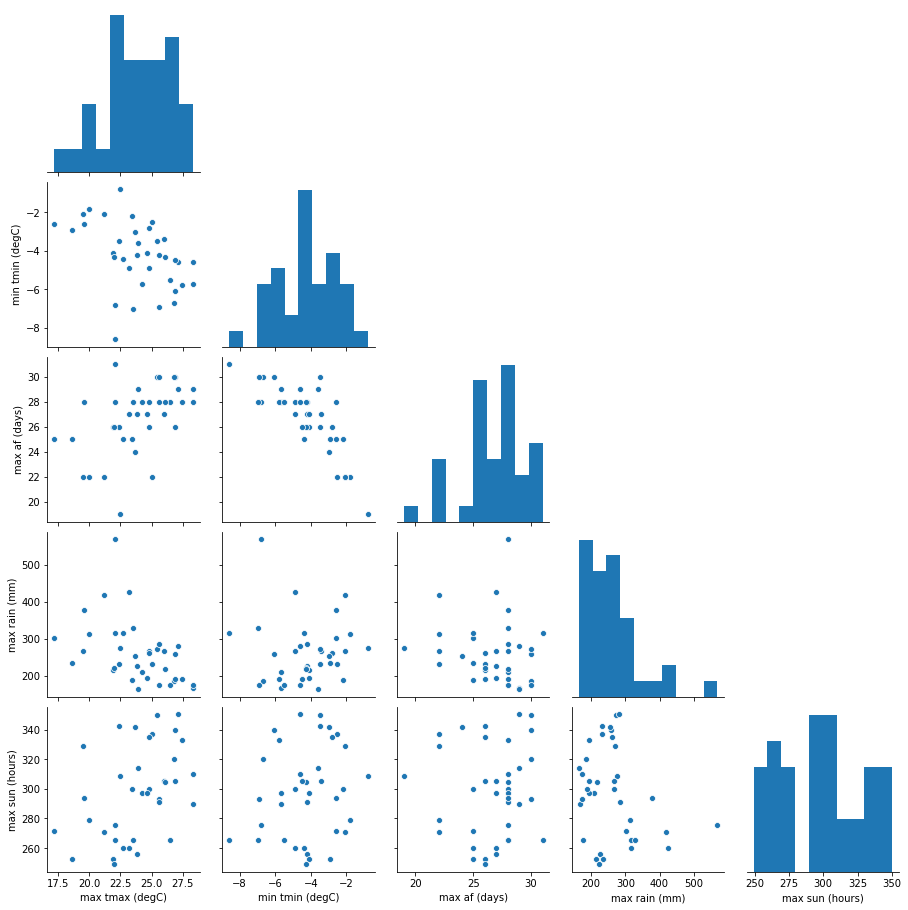

In [12]:
# view pairplot of the stations_aggregates data
sns.pairplot(stations_aggregates, corner=True)

========Feature matrix======== 

 [[22.4 -3.5]
 [23.8 -4.2]
 [20.  -1.8]
 [24.8 -4.9]
 [22.1 -8.6]
 [22.5 -0.8]
 [28.3 -5.7]
 [26.  -3.4]
 [25.  -2.5]
 [23.2 -4.9]
 [21.2 -2.1]
 [24.2 -5.7]
 [24.8 -2.8]
 [22.1 -6.8]
 [28.3 -4.6]
 [26.9 -6.1]
 [17.2 -2.6]
 [21.9 -4.1]
 [23.9 -3.6]
 [25.4 -3.5]
 [22.  -4.3]
 [23.5 -7. ]
 [27.4 -5.8]
 [22.7 -4.4]
 [24.6 -4.1]
 [26.8 -6.7]
 [25.6 -6.9]
 [25.6 -4.2]
 [27.1 -4.6]
 [19.6 -2.6]
 [26.5 -5.5]
 [19.5 -2.1]
 [23.7 -3. ]
 [26.1 -4.3]
 [23.4 -2.2]
 [18.6 -2.9]
 [26.9 -4.5]]



========Cluster centers======== 

 [[20.91666667 -2.78333333]
 [25.304      -4.956     ]] 



========Plot of the two clusters========


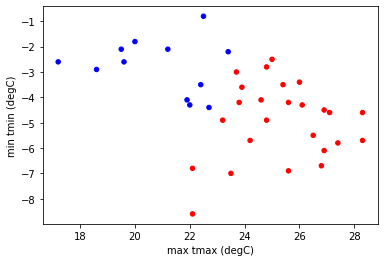

In [13]:
# cluster weather data based on 'max tmax' and 'min tmin'
df = stations_aggregates
tmax_tmin = df[['max tmax (degC)','min tmin (degC)']]
X = tmax_tmin.to_numpy()
print(f'========Feature matrix======== \n\n {X}\n\n\n')

# initialize KMeans object
kmeans = KMeans(n_clusters=2, random_state=0)

# fit the data
kmeans.fit(X)

print(f'========Cluster centers======== \n\n {kmeans.cluster_centers_} \n\n\n')

# plot the clusters
print('========Plot of the two clusters========')
tmax_tmin['label'] = kmeans.labels_
tmax_tmin.columns = ['max tmax (degC)','min tmin (degC)','label']
color_dict = {0:'blue',
             1:'red'}
tmax_tmin['color'] = tmax_tmin['label'].apply(lambda x:color_dict[x])
tmax_tmin.plot.scatter(x='max tmax (degC)',y='min tmin (degC)',c=tmax_tmin['color'])

========Feature matrix======== 

 [[ 22.4 342.1]
 [ 23.8 256. ]
 [ 20.  279.3]
 [ 24.8 300.1]
 [ 22.1 265.2]
 [ 22.5 308.4]
 [ 28.3 289.6]
 [ 26.  305.4]
 [ 25.  336.8]
 [ 23.2 260.2]
 [ 21.2 270.9]
 [ 24.2 297. ]
 [ 24.8 335.3]
 [ 22.1 275.9]
 [ 28.3 310.1]
 [ 26.9 339.5]
 [ 17.2 271.5]
 [ 21.9 252.6]
 [ 23.9 314.4]
 [ 25.4 350.1]
 [ 22.  249.1]
 [ 23.5 265.3]
 [ 27.4 333. ]
 [ 22.7 259.9]
 [ 24.6 297.5]
 [ 26.8 320.1]
 [ 25.6 292.9]
 [ 25.6 290.8]
 [ 27.1 350.3]
 [ 19.6 294.1]
 [ 26.5 265.4]
 [ 19.5 329.1]
 [ 23.7 341.4]
 [ 26.1 304.5]
 [ 23.4 299.9]
 [ 18.6 252.9]
 [ 26.9 305.6]]



========Cluster centers======== 

 [[ 24.98571429 300.73571429]
 [ 24.9        337.77      ]
 [ 21.90769231 263.4       ]] 



========Plot of the three clusters========


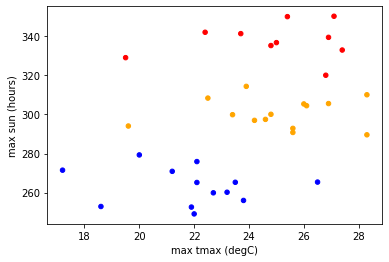

In [14]:
# cluster weather data based on 'max tmax' and 'max sun'
df = stations_aggregates
tmax_sun = df[['max tmax (degC)','max sun (hours)']]
X = tmax_sun.to_numpy()
print(f'========Feature matrix======== \n\n {X}\n\n\n')

# initialize KMeans object
kmeans = KMeans(n_clusters=3, random_state=0)

# fit the data
kmeans.fit(X)

print(f'========Cluster centers======== \n\n {kmeans.cluster_centers_} \n\n\n')

# plot the clusters
print('========Plot of the three clusters========')
tmax_sun['label'] = kmeans.labels_
tmax_sun.columns = ['max tmax (degC)','max sun (hours)','label']
color_dict = {0:'orange',
             1:'red',
             2:'blue'}
tmax_sun['color'] = tmax_sun['label'].apply(lambda x:color_dict[x])
tmax_sun.plot.scatter(x='max tmax (degC)',y='max sun (hours)',c=tmax_sun['color'])

========Feature matrix======== 

 [[ 22.4 232.3]
 [ 23.8 226.4]
 [ 20.  313. ]
 [ 24.8 266.8]
 [ 22.1 316.8]
 [ 22.5 276.7]
 [ 28.3 166.2]
 [ 26.  267.6]
 [ 25.  233. ]
 [ 23.2 425.4]
 [ 21.2 417.8]
 [ 24.2 209.7]
 [ 24.8 261.1]
 [ 22.1 568.8]
 [ 28.3 174.8]
 [ 26.9 258.9]
 [ 17.2 302.4]
 [ 21.9 215.6]
 [ 23.9 163.9]
 [ 25.4 271.8]
 [ 22.  222.4]
 [ 23.5 329.4]
 [ 27.4 192.9]
 [ 22.7 315.6]
 [ 24.6 193.6]
 [ 26.8 186. ]
 [ 25.6 174.7]
 [ 25.6 285.6]
 [ 27.1 280.7]
 [ 19.6 377.5]
 [ 26.5 176.5]
 [ 19.5 268.6]
 [ 23.7 254.2]
 [ 26.1 217.5]
 [ 23.4 189. ]
 [ 18.6 234.6]
 [ 26.9 192.4]]



========Cluster centers======== 

 [[ 24.76111111 200.08333333]
 [ 21.525      447.375     ]
 [ 23.45333333 284.61333333]] 



========Plot of the three clusters========


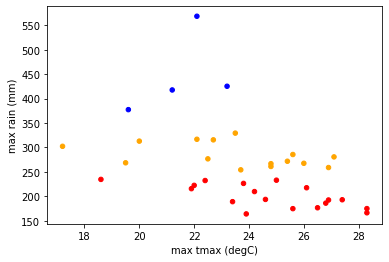

In [15]:
# cluster weather data based on 'max tmax' and 'max rain'
df = stations_aggregates
tmax_rain = df[['max tmax (degC)','max rain (mm)']]
X = tmax_rain.to_numpy()
print(f'========Feature matrix======== \n\n {X}\n\n\n')

# initialize KMeans object
kmeans = KMeans(n_clusters=3, random_state=0)

# fit the data
kmeans.fit(X)

print(f'========Cluster centers======== \n\n {kmeans.cluster_centers_} \n\n\n')

# plot the clusters
print('========Plot of the three clusters========')
tmax_rain['label'] = kmeans.labels_
tmax_rain.columns = ['max tmax (degC)','max rain (mm)','label']
color_dict = {0:'red',
             1:'blue',
             2: 'orange'}
tmax_rain['color'] = tmax_rain['label'].apply(lambda x:color_dict[x])
tmax_rain.plot.scatter(x='max tmax (degC)',y='max rain (mm)',c=tmax_rain['color'])